<a href="https://colab.research.google.com/github/koba-works/enap_PLN_2024/blob/main/Kaggle/exerc_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'enap-anlise-de-sentimentos:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F73427%2F8101446%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240415%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240415T224222Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dd0a4fabf1966d9be3a59e3f2831fc10b568ec321c040f11cfc9f7ec1a2f884578e38b29fe4572b30a04ed843a35c6e247b54b5f74240349e7d1b86c8ea2d7e3d207d4b2bd4407fe65cc99581f0ce90184ee81fb88147e51250dace59e48c2e8cb22cdeef5eaab1bb37ae8e1989c06f161ae75893da88a5063a5478940398da9a567989140926083df2078b8b626b9b4c2a9fd1d1d3c5ff38536967dc33bfe66e613d4a3e4de5cd2274da0d27e94b0b639be8738e6b1e316f6dc44e5ccfdf1b35c1f41cbdc59a136a5f0b616d78e95f2370fae3b55bc2900c739ee5fe5b8b14e44fc3d6ba86cee17438bcf23ae217bdf7fb4b7f3b56aeebde0d56aac0bdde06c9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4132713 bytes downloaded
Downloaded and uncompressed: enap-anlise-de-sentimentos
Data source import complete.


# Exercício de Classificação de Análise de Sentimentos

O objetivo do exercício é explorar técnicas de pré-processamento de texto, como remoção de stopwords, tokenização e stemming, além de aplicar técnicas de vetorização, como Bag of Words (BoW) e Term Frequency-Inverse Document Frequency (TF-IDF) para classificar a polaridade de tweets em positivas ou negativas.

## Importar bibliotecas, carregar datasets, etc.

In [ ]:
# importar bibliotecas basicas:
import random
import pandas as pd
import matplotlib as plot
import seaborn as sns

# bibliotecas complementares
import codecs
import nltk
import re
import spacy
import string
import unicodedata

In [ ]:
# aleatoriedade controlada
random.seed(42)

In [ ]:
# carregar dataset de treino
train = pd.read_csv('/kaggle/input/enap-anlise-de-sentimentos/train.csv', index_col=0)

## Pré analise

In [ ]:
# Pré avaliação do dataset que está sendo carregado
print(train)

                                                      text  target
ID                                                                
1439813  @sweet19 thanksies but ur so lucky u are in hi...       4
621715                at the park playing tennis. i suck.        0
1188021               @tontokaru happy belated bday babe!        4
300651              @DxBLOCK  DM me your number again pls        0
757974                           Rest in Peace Ed McMahon        0
...                                                    ...     ...
1312263  @conc3p  &quot;I want him to watch&quot; + &qu...       4
143846                       @gershgorin that's awful!!!!        0
1253750  @HipMamaB LOL - I remember that episode!!  (wh...       4
134415                          @cooliesupreme I am sorry        0
1218280     @sesam not to worry, I don't use lifts either        4

[70000 rows x 2 columns]


Dá pra notar que tem muita 💩 no texto...
exemplos:
* uso de simbolos: @ ! ; + &
* girias: LOL DM bday ur
* erro de grafias: thanksies


In [ ]:
train.dropna()
train.columns = ['text','target']
train.head()

,text,target
ID,,
1439813,@sweet19 thanksies but ur so lucky u are in hi...,4
621715,at the park playing tennis. i suck.,0
1188021,@tontokaru happy belated bday babe!,4
300651,@DxBLOCK DM me your number again pls,0
757974,Rest in Peace Ed McMahon,0


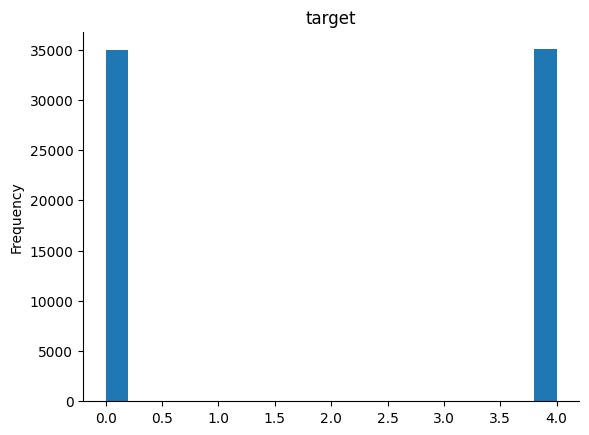

In [ ]:
# @title distribuição das classes alvo

from matplotlib import pyplot as plt
train['target'].plot(kind='hist', bins=20, title='target')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Avaliação de distribuição das classes alvo

In [ ]:
balance_counts = train.groupby('target')['target'].agg('count').values
balance_counts

array([34970, 35030])

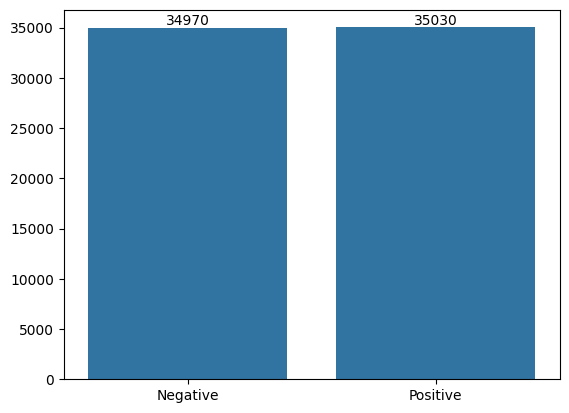

In [ ]:
# Analise grafica para avaliar possível desbalanceamento de classes alvo

import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar chart of the target counts
sns.barplot(x=['Negative', 'Positive'], y=balance_counts)

# Add labels to the bars
for i, value in enumerate(balance_counts):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Show the plot
plt.show()

## Pre-processamento

### Limpeza do corpus de treinamento

In [ ]:
'''texto em minúsculas, remova o texto entre colchetes, remova links, remova pontuações e remova palavras que contenham números.'''

def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
train['text_clean'] = train['text'].apply(clean_text)
train.head()

,text,target,text_clean
ID,,,
1439813,@sweet19 thanksies but ur so lucky u are in hi...,4,thanksies but ur so lucky u are in high schoo...
621715,at the park playing tennis. i suck.,0,at the park playing tennis i suck
1188021,@tontokaru happy belated bday babe!,4,tontokaru happy belated bday babe
300651,@DxBLOCK DM me your number again pls,0,dxblock dm me your number again pls
757974,Rest in Peace Ed McMahon,0,rest in peace ed mcmahon


In [ ]:
X_train, y_train = train['text'], train['target']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X_train)

In [ ]:
X_vectorized

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_vectorized, y_train)

In [ ]:
X_test = pd.read_csv('/kaggle/input/enap-anlise-de-sentimentos/test.csv', index_col=0)

In [ ]:
X_test = X_test['text']

In [ ]:
X_vectorized = vectorizer.transform(X_test)

In [ ]:
X_vectorized

In [ ]:
y_pred = nb_model.predict(X_vectorized)

In [ ]:
y_pred

In [ ]:
pred = pd.DataFrame({'target': y_pred}, index=X_test.index)

print(pred)

In [ ]:
pred.to_csv('/kaggle/working/submission.csv')